In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [105]:
import geopandas as gpd
from shapely.geometry import Polygon
from shapely import wkt
from shapely import wkb
from fiona.crs import from_epsg
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.patches as mpatches

from sentinelsat import SentinelAPI
import pandas as pd
from datetime import datetime
from datetime import date
import glob
from collections import OrderedDict
import os
import csv
import random

import numpy as np

import requests
import json
import getpass

from tqdm import tqdm

from utils.prep_utils import s3_list_objects_paths, s3_list_objects, s3_download, s3_upload_cogs, create_yaml, get_geometry
from utils.prepS1 import get_s1_asf_urls


In [4]:
print(os.environ['AWS_ACCESS_KEY_ID'])
print(os.environ['AWS_S3_ENDPOINT'])
print(os.environ['COPERNICUS_USERNAME'])
print(os.environ['ASF_USERNAME'])

16c353e3c1673eb9556e
s3-uk-1.sa-catapult.co.uk
tmj21
tom_jones


In [7]:
# req
country = 'Fiji' 
# optional
inter_dir = '../data/'
s3upload = True
s3_bucket = 'public-eo-data'
jobs_s3dir = 'common_sensing/tom/dataprep_jobs/'

# **Prep AoI Vectors and Ancillary datasets**
- global sentinel-2 tile shapefile
- global landsat tile shapefile
- world borders shapefile (from TM_WORLD_BORDERS)

In [8]:
# anc s3 locs
anc_s2tiles_s3 = 'common_sensing/ancillary_products/SatelliteSceneTiles/sentinel2_tiles_world/sentinel2_tiles_world.shp'
anc_lstiles_s3 = 'common_sensing/ancillary_products/SatelliteSceneTiles/landsat_pr/WRS2_descending.shp'
anc_wborders_s3 = 'common_sensing/ancillary_products/TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.2.shp'
# anc web locs - TBD
anc_ls_acqs = { 
    'LANDSAT_4': 'url',
    'LANDSAT_4': 'url',
    'LANDSAT_4': 'url',
    'LANDSAT_4': 'url',
    'LANDSAT_4': 'url'
}

In [11]:
# # check s3 bucket

# # download missing
# loc_path = './'
# remote_path = '/'
# if not os.path.exists(loc_path):

## Sentinel-2 & Landsat Tiles

In [12]:
# Load landsat & sentinel-2 world tiles
world_s2_granules = gpd.read_file('../data/ancillary/sentinel2_tiles_world.shp')
world_ls_granules = gpd.read_file('../data/ancillary/WRS2_descending.shp')

## World Borders (for consistent aois)

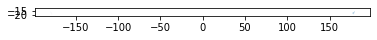

In [13]:
world_borders = gpd.read_file('../data/ancillary/TM_WORLD_BORDERS-0.2.shp')
country_name = country
country = world_borders.loc[world_borders.NAME == country_name]
country.plot()

In [14]:
# Add antimeridian
g = "LINESTRING(180 -12,180 -21)"
# geopandas dataframe for plotting
g = pd.DataFrame(data={'geometry': [g]})
g['geometry'] = g['geometry'].apply(wkt.loads)
g = gpd.GeoDataFrame(g, geometry='geometry', crs=('epsg:4326'))
g.crs = from_epsg(4326)

## Determine tiles overlapping country border(s) & plot (in local crs)

In [15]:
# Create bool for intersection between any tiles 
for n, g in zip(country.NAME, country.geometry):
    world_ls_granules[n] = world_ls_granules.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(g))
    world_s2_granules[n] = world_s2_granules.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(g))

In [16]:
# Filter based on any True intersections
world_ls_granules[country_name] = world_ls_granules[world_ls_granules[country.NAME.values]].any(1)
country_ls_grans = world_ls_granules[world_ls_granules[country_name]==True]
world_s2_granules[country_name] = world_s2_granules[world_s2_granules[country.NAME.values]].any(1)
country_s2_grans = world_s2_granules[world_s2_granules[country_name]==True]

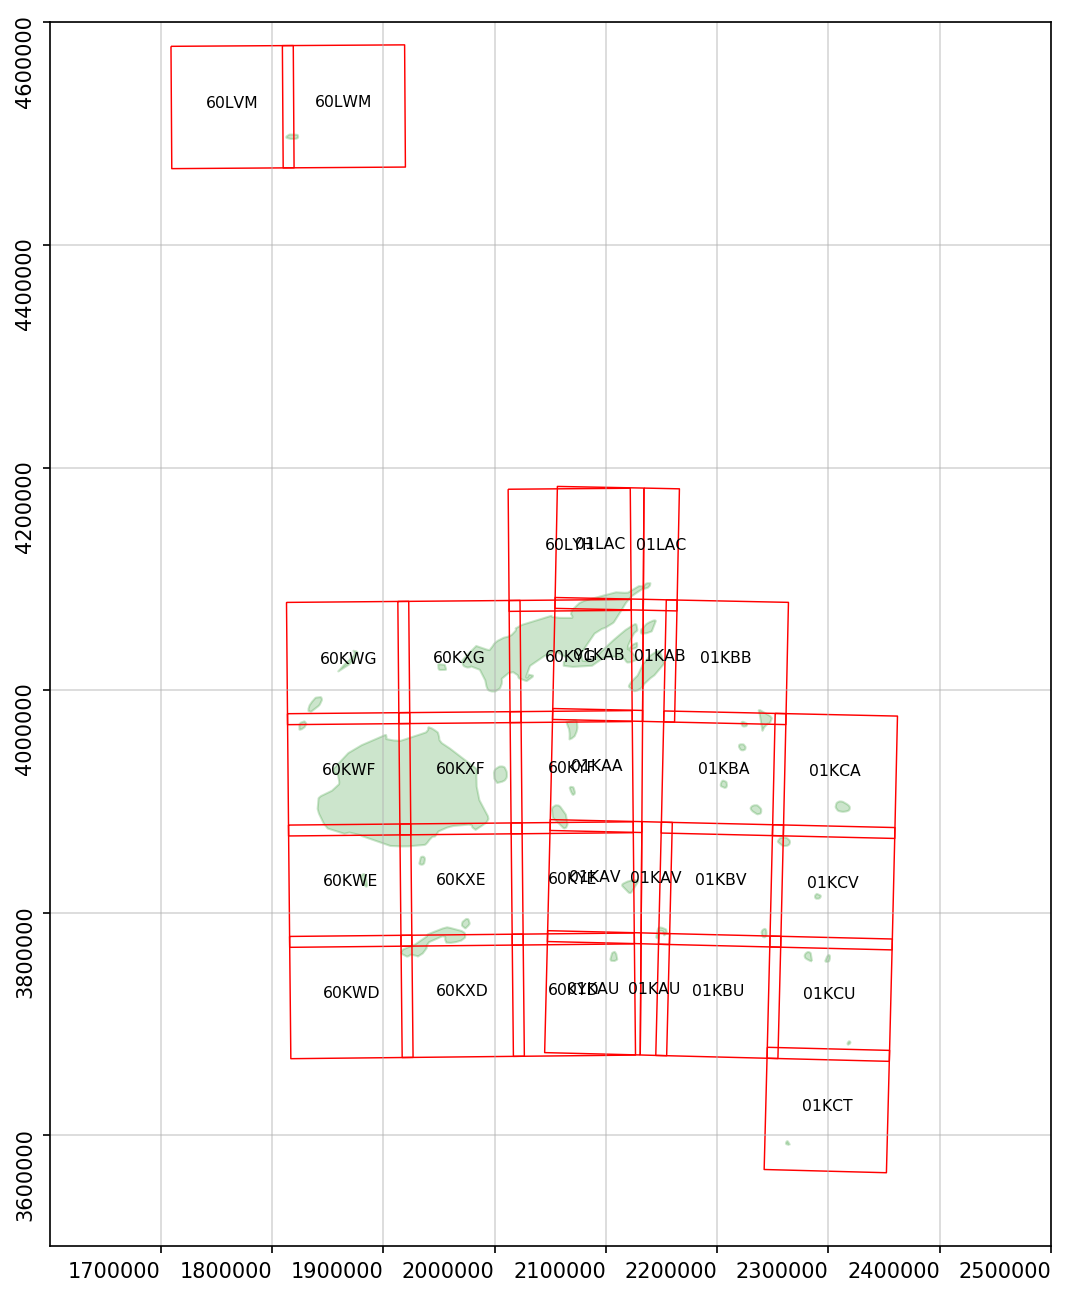

In [17]:
# Plot coverage
fig, ax = plt.subplots(figsize=(12,12),dpi=150)
fig.autofmt_xdate()
leg_patches=[]

# x = g.to_crs({"init": "epsg:3460"}).plot(edgecolor='black', ax=ax, alpha=0.1)
# leg_patches.append(mpatches.Patch(facecolor='none', edgecolor='black', lw=0.7, label='Anti-meridian'))

x = country.to_crs({"init": "epsg:3460"}).plot(facecolor="g", edgecolor='g', ax=ax, alpha=0.2);
leg_patches.append(mpatches.Patch(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, label=country_name))

x = country_s2_grans.to_crs({"init": "epsg:3460"}).plot(facecolor="none", edgecolor='r', lw=0.7, ax=ax)
leg_patches.append(mpatches.Patch(facecolor="none", edgecolor='r', lw=0.7, label='Sentinel-2 Tiles'))
country_s2_grans.to_crs({"init": "epsg:3460"}).apply(lambda x: ax.annotate(s=x.Name, xy=x.geometry.centroid.coords[0], ha='center', fontsize=7.5),axis=1)

# x = country_ls_grans.to_crs({"init": "epsg:3460"}).plot(facecolor="none", edgecolor='b', lw=0.7, ax=ax)
# leg_patches.append(mpatches.Patch(facecolor="none", edgecolor='b', lw=0.7, label='Landsat Tiles'))
# country_ls_grans.to_crs({"init": "epsg:3460"}).apply(lambda x: ax.annotate(s=x.PR, xy=x.geometry.centroid.coords[0], ha='center', fontsize=7.5),axis=1)

# ax.set_title('asf')
# ax.legend(handles=leg_patches, loc='upper center', shadow=True, ncol=5);
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);
ax.set_xlim(1600001, 2500000);
ax.set_ylim(3500000, 4600000);

# **(1) Sentinel-2**

- **query esa hub** both l1c + l2a for full envelope of AoI (unfortunately must be simple, single geometry)
- **create l1c shortened 'scene name'** in both dfs 
- filter l1c to **remove scenes already available in l2a**
- filter both dfs to only **tiles that precisely overlap aoi** (i.e. above) -- ***potential for two tiles to have been missed...***

to do
- query gcloud csv both l1c & l2a
- remove gcloud duplicates
- 
- cross-reference gcloud for both dfs
- primary gcloud hit list for both l2a & l1c
- back-up sentinelsat hit list for both l2a & l1c
- consolidated job list


# Query **ESA** for L1C and L2A via sentinelsat

In [18]:
# Recreate aois (in case crs has changed)
country_name = 'Fiji'
aois = world_borders.loc[world_borders.NAME == country_name]
# Determine wkt envelope (must be done in 3460 then re-reprojected to avoid antimeridian)
aoi_wkt = aois.to_crs({"init": "epsg:3460"}).envelope.to_crs({"init": "epsg:4326"}).values[0].wkt

In [19]:
# Login to esa api
esa_api = SentinelAPI(os.environ['COPERNICUS_USERNAME'],os.environ['COPERNICUS_PWD'])

In [35]:
# l2a results
res = esa_api.query(aoi_wkt, platformname='Sentinel-2',producttype='S2MSI2A')
esa_l2a = esa_api.to_geodataframe(res)

Querying products: 100%|██████████| 8179/8179 [04:23<00:00, 31.09 products/s]


In [21]:
# l1c results
res = esa_api.query(aoi_wkt, platformname='Sentinel-2', producttype='S2MSI1C')
esa_l1c = esa_api.to_geodataframe(res)
l1c = esa_l1c

Querying products: 100%|██████████| 18894/18894 [10:26<00:00, 30.16 products/s]


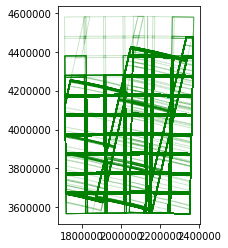

In [22]:
esa_l1c.to_crs({"init": "epsg:3460"}).plot(facecolor="", edgecolor='g', alpha=0.2)

## Shorten ESA df **scene names** [& check earliest acquisitions & check anomalous tiles]

In [36]:
# Add shortened scene name
esa_l1c['scenename'] = esa_l1c.title.apply(lambda x: f"{x.split('_')[0]}_{x.split('_')[1]}_{x.split('_')[2]}_{x.split('_')[5]}")
esa_l2a['scenename'] = esa_l2a.title.apply(lambda x: f"{x.split('_')[0]}_MSIL1C_{x.split('_')[2]}_{x.split('_')[5]}")
esa_l1c['granules'] = esa_l1c.identifier.str[39:44]
esa_l2a['granules'] = esa_l2a.identifier.str[39:44]

In [37]:
# CHECK EARLIEST ACQUISITIONS ALIGN WITH KNOWN AVAILABILITY
esa_l1c = esa_l1c.sort_values('beginposition', ascending=True)
esa_l2a = esa_l2a.sort_values('beginposition', ascending=True)
print(f'Tot. No. L1C Prods: {len(esa_l1c)} | Tot. No. L2A Prods: {len(esa_l2a)}')
print('First 2, last 2 products...')
print(list(esa_l1c.title.values[:2]))
print(list(esa_l2a.title.values[:2]))
print(list(esa_l1c.title.values[-2:]))
print(list(esa_l2a.title.values[-2:]))
print('Sorted...')
esa_l1c_srt = esa_l1c.sort_values('beginposition', ascending=False)
esa_l2a_srt = esa_l2a.sort_values('beginposition', ascending=False)
print(list(esa_l1c_srt.title.values[-2:]))
print(list(esa_l2a_srt.title.values[-2:]))

Tot. No. L1C Prods: 18894 | Tot. No. L2A Prods: 8179
First 2, last 2 products...
['S2A_MSIL1C_20151002T222056_N0204_R029_T01KBU_20151002T222058', 'S2A_MSIL1C_20151002T222056_N0204_R029_T01KAU_20151002T222058']
['S2B_MSIL2A_20181213T223009_N0211_R072_T60KWG_20181214T000745', 'S2B_MSIL2A_20181213T223009_N0211_R072_T60LVH_20181214T000745']
['S2A_MSIL1C_20200421T223011_N0209_R072_T60LXJ_20200421T235054', 'S2A_MSIL1C_20200421T223011_N0209_R072_T60LXH_20200421T235054']
['S2A_MSIL2A_20200421T223011_N0214_R072_T60LXJ_20200422T002013', 'S2A_MSIL2A_20200421T223011_N0214_R072_T60KWG_20200422T002013']
Sorted...
['S2A_MSIL1C_20151002T222056_N0204_R029_T01KAU_20151002T222058', 'S2A_MSIL1C_20151002T222056_N0204_R029_T01KBU_20151002T222058']
['S2B_MSIL2A_20181213T223009_N0211_R072_T60KXE_20181214T000745', 'S2B_MSIL2A_20181213T223009_N0211_R072_T60KWG_20181214T000745']


In [38]:
# Check naming convention consistent throughout (i.e. not larger scenes...) - tiles within titles seems easiest method
# Check no. tiles found from ESA against no. from precise search
# esa_l1c_srt['ttl'] = esa_l1c_srt.title.apply(lambda x: x.split('_')[5])
# esa_l2a_srt['tileid'] = esa_l2a_srt.title.apply(lambda x: x.split('_')[5][1:])
# print(f'Unique tiles: {set(esa_l1c_srt.granules.values)} | No. Unique tiles: {len(set(esa_l1c_srt.granules.values))} | No. Unique tiles (precise): {len(set(country_s2_grans.Name.values))}')

## **Filter out L1C scenes** already processed to L2A & Remove tiles outside **precise AoI**

In [39]:
# Filter L1C scenes that have already been processed to L2A
print(f'Tot No. L1C Scenes (AoI Envelope): {esa_l1c_srt.shape}')
esa_l1c_srt = esa_l1c_srt.loc[~esa_l1c_srt['scenename'].isin(esa_l2a_srt.scenename.values)]
print(f'No. nonL2A L1C Scenes (AoI Envelope): {esa_l1c_srt.shape}')
print(f'No. L2A Scenes (AoI Envelope): {esa_l2a_srt.shape}')

Tot No. L1C Scenes (AoI Envelope): (18894, 36)
No. nonL2A L1C Scenes (AoI Envelope): (10715, 36)
No. L2A Scenes (AoI Envelope): (8179, 37)


In [40]:
# Filter search results to specific tiles needed (i.e. from tiles shapefile)
esa_l1c_precise = esa_l1c_srt[esa_l1c_srt['granules'].isin(country_s2_grans.Name.values)]
esa_l2a_precise = esa_l2a_srt[esa_l2a_srt['granules'].isin(country_s2_grans.Name.values)]
print(f'No. nonL2A L1C Scenes (Precise Tiles): {esa_l1c_precise.shape}')
print(f'No. L2A Scenes (Precise Tiles): {esa_l2a_precise.shape}')

No. nonL2A L1C Scenes (Precise Tiles): (5296, 36)
No. L2A Scenes (Precise Tiles): (3807, 37)


# Query **GCloud** for L1C and L2A via .csv

In [28]:
# Get tile names from ESA S2 tiles shapefile (from above)
s2_tiles = list(country_s2_grans.Name.values)
len(s2_tiles)

32

In [29]:
# Read all GCloud L1C acquisitions and filter to those of desired tiles
gc = pd.read_csv('../data/ancillary/L1_index.csv.gz')
gc_l1c = gc[ gc.MGRS_TILE.isin(s2_tiles) ]
gc = None
# Read all GCloud L2A acquisitions and filter to those of desired tiles
gc = pd.read_csv('../data/ancillary/L2_index.csv.gz')
gc_l2a = gc[ gc.MGRS_TILE.isin(s2_tiles) ]
gc = None

In [30]:
# Create shortened name as with esa
print(f'Tot No. L2A GCloud Scenes (Precise Tiles): {gc_l2a.shape}')
print(f'Tot No. L1C GCloud Scenes (Precise Tiles): {gc_l1c.shape}')
gc_l2a['scenename'] = gc_l2a.PRODUCT_ID.apply(lambda x: f"{x.split('_')[0]}_MSIL1C_{x.split('_')[2]}_{x.split('_')[5]}")
gc_l1c['scenename'] = gc_l1c.PRODUCT_ID.apply(lambda x: f"{x.split('_')[0]}_MSIL1C_{x.split('_')[2]}_{x.split('_')[5]}")

Tot No. L2A GCloud Scenes (Precise Tiles): (3824, 14)
Tot No. L1C GCloud Scenes (Precise Tiles): (9513, 14)


In [43]:
# Filter to only scenes that match esa
gc_l2a_match = gc_l2a.loc[gc_l2a['scenename'].isin(esa_l2a_precise.scenename.values)]
gc_l1c_match = gc_l1c.loc[gc_l1c['scenename'].isin(esa_l1c_precise.scenename.values)]
print(f'Tot No. L2A GCloud cross-referenced Scenes (Precise Tiles): {gc_l2a_match.shape}')
print(f'Tot No. L2A GCloud cross-referenced Scenes (Precise Tiles): {gc_l1c_match.shape}')

Tot No. L2A GCloud cross-referenced Scenes (Precise Tiles): (3823, 15)
Tot No. L2A GCloud cross-referenced Scenes (Precise Tiles): (5125, 15)


In [44]:
# Filter L1C scenes that have already been processed to L2A
print(f'Tot No. L1C Scenes (Precise AoI): {gc_l1c_match.shape}')
gc_l1c_match = gc_l1c_match.loc[~gc_l1c_match['scenename'].isin(gc_l2a_match.scenename.values)]
print(f'No. nonL2A L1C Scenes (Precise AoI): {gc_l1c_match.shape}')
print(f'No. L2A Scenes (Precise AoI): {gc_l2a_match.shape}')

Tot No. L1C Scenes (Precise AoI): (5125, 15)
No. nonL2A L1C Scenes (Precise AoI): (5125, 15)
No. L2A Scenes (Precise AoI): (3823, 15)


# **Sanity check final hit list**

In [45]:
print(f'ESA Original Query Results \n L2A No. Acquisitions: {esa_l2a.shape[0]} \n L2A No. Tiles: {len(set(esa_l2a.granules.values))} \n L1C No. Acquisitions: {esa_l1c.shape[0]} \n L1C No. Tiles: {len(set(esa_l1c.granules.values))} \n')
print(f'ESA Remove L1C/L2A duplicates Query Results \n L2A No. Acquisitions: {esa_l2a_srt.shape[0]} \n L2A No. Tiles: {len(set(esa_l2a_srt.granules.values))} \n L1C No. Acquisitions: {esa_l1c_srt.shape[0]} \n L1C No. Tiles: {len(set(esa_l1c.granules.values))} \n')
print(f'ESA Remove L1C/L2A duplicates + precise AoI Query Results \n L2A No. Acquisitions: {esa_l2a_precise.shape[0]} \n L2A No. Tiles: {len(set(esa_l2a_precise.granules.values))} \n L1C No. Acquisitions: {esa_l1c_precise.shape[0]} \n L1C No. Tiles: {len(set(esa_l1c_precise.granules.values))} \n')
print(f'Gcloud Original Tile Query Results \n L2A No. Acquisitions: {gc_l2a.shape[0]} \n L2A No. Tiles: {len(set(gc_l2a.MGRS_TILE.values))} \n L1C No. Acquisitions: {gc_l1c.shape[0]} \n L2A No. Tiles: {len(set(gc_l1c.MGRS_TILE.values))} \n')
print(f'Gcloud Matched SceneName Query Results \n L2A No. Acquisitions: {gc_l2a_match.shape[0]} \n L2A No. Tiles: {len(set(gc_l2a_match.MGRS_TILE.values))} \n L1C No. Acquisitions: {gc_l1c_match.shape[0]} \n L1C No. Tiles: {len(set(gc_l1c_match.MGRS_TILE.values))} \n')

ESA Original Query Results 
 L2A No. Acquisitions: 8179 
 L2A No. Tiles: 70 
 L1C No. Acquisitions: 18894 
 L1C No. Tiles: 70 

ESA Remove L1C/L2A duplicates Query Results 
 L2A No. Acquisitions: 8179 
 L2A No. Tiles: 70 
 L1C No. Acquisitions: 10715 
 L1C No. Tiles: 70 

ESA Remove L1C/L2A duplicates + precise AoI Query Results 
 L2A No. Acquisitions: 3807 
 L2A No. Tiles: 28 
 L1C No. Acquisitions: 5296 
 L1C No. Tiles: 26 

Gcloud Original Tile Query Results 
 L2A No. Acquisitions: 3824 
 L2A No. Tiles: 28 
 L1C No. Acquisitions: 9513 
 L2A No. Tiles: 28 

Gcloud Matched SceneName Query Results 
 L2A No. Acquisitions: 3823 
 L2A No. Tiles: 28 
 L1C No. Acquisitions: 5125 
 L1C No. Tiles: 26 



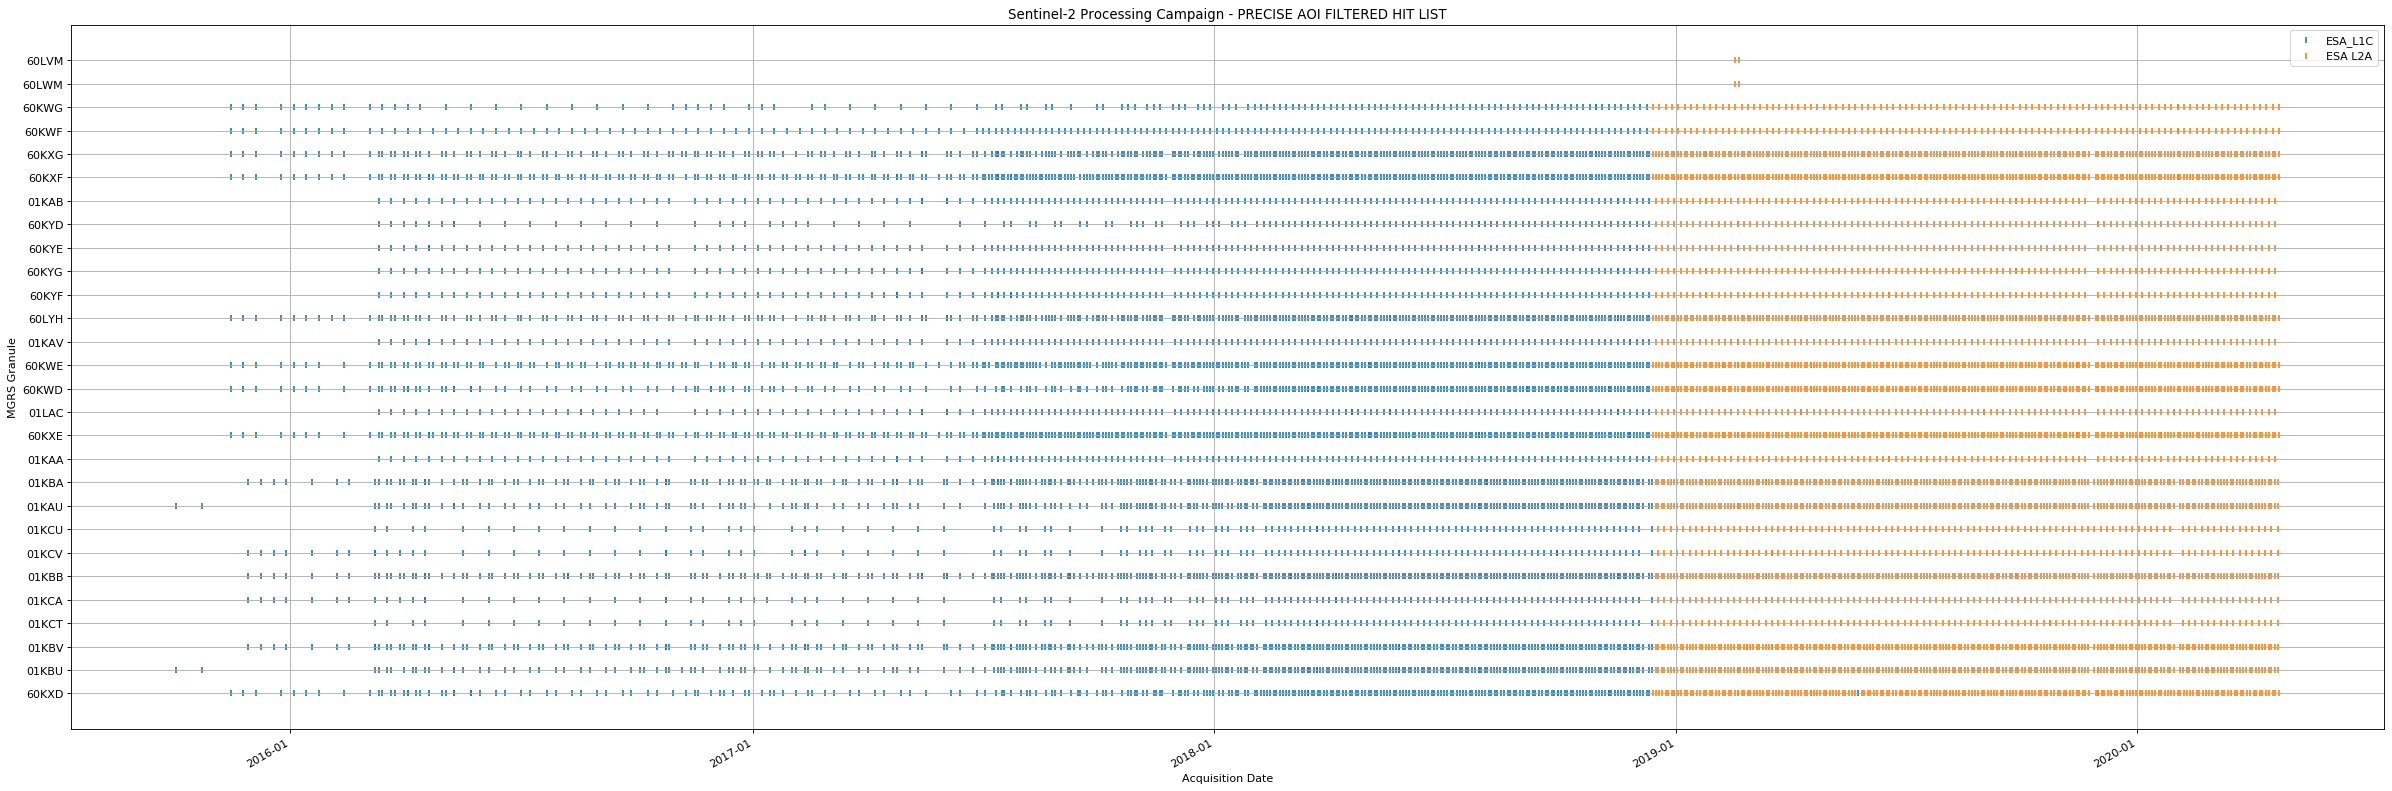

In [86]:
# Plot temporality of L1C and L2A
fig, ax = plt.subplots(figsize=(30,10),dpi=80)
fig.autofmt_xdate()

df = esa_l1c_precise
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
#df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]
ax.scatter(df['Acquisition Date'].values, df['granules'].values, marker='|');

df = esa_l2a_precise
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
#df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]
ax.scatter(df['Acquisition Date'].values, df['granules'].values, marker='|');

# df = gc_l1c_match
# df['Acquisition Date'] = pd.to_datetime(df['SENSING_TIME'], format='%Y-%m-%d', utc=True)
# df['granules'] = df['MGRS_TILE']
# # remove files showing as NaN size
# df = df.dropna(subset=['TOTAL_SIZE'])
# #df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]
# ax.scatter(df['Acquisition Date'].values, df['granules'].values, marker='_');

# df = gc_l2a_match
# df['Acquisition Date'] = pd.to_datetime(df['SENSING_TIME'], format='%Y-%m-%d', utc=True)
# df['granules'] = df['MGRS_TILE']
# # remove files showing as NaN size
# df = df.dropna(subset=['TOTAL_SIZE'])
# #df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]
# ax.scatter(df['Acquisition Date'].values, df['granules'].values, marker='|');

ax.set_ylabel('MGRS Granule');
ax.set_xlabel("Acquisition Date");
ax.legend(['ESA_L1C','ESA L2A','USGS_L4-5TM','USGS_L1-4MSS']);
ax.set_title("Sentinel-2 Processing Campaign - PRECISE AOI FILTERED HIT LIST");
ax.xaxis.set_major_locator(mdates.AutoDateLocator());
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m") ); 
ax.grid(which='both')
fig.tight_layout()
#fig.savefig('../Search_Discovery/Fiji_S1_tempdistribution_orbitdirection');

AttributeError: 'Series' object has no attribute 'Name'

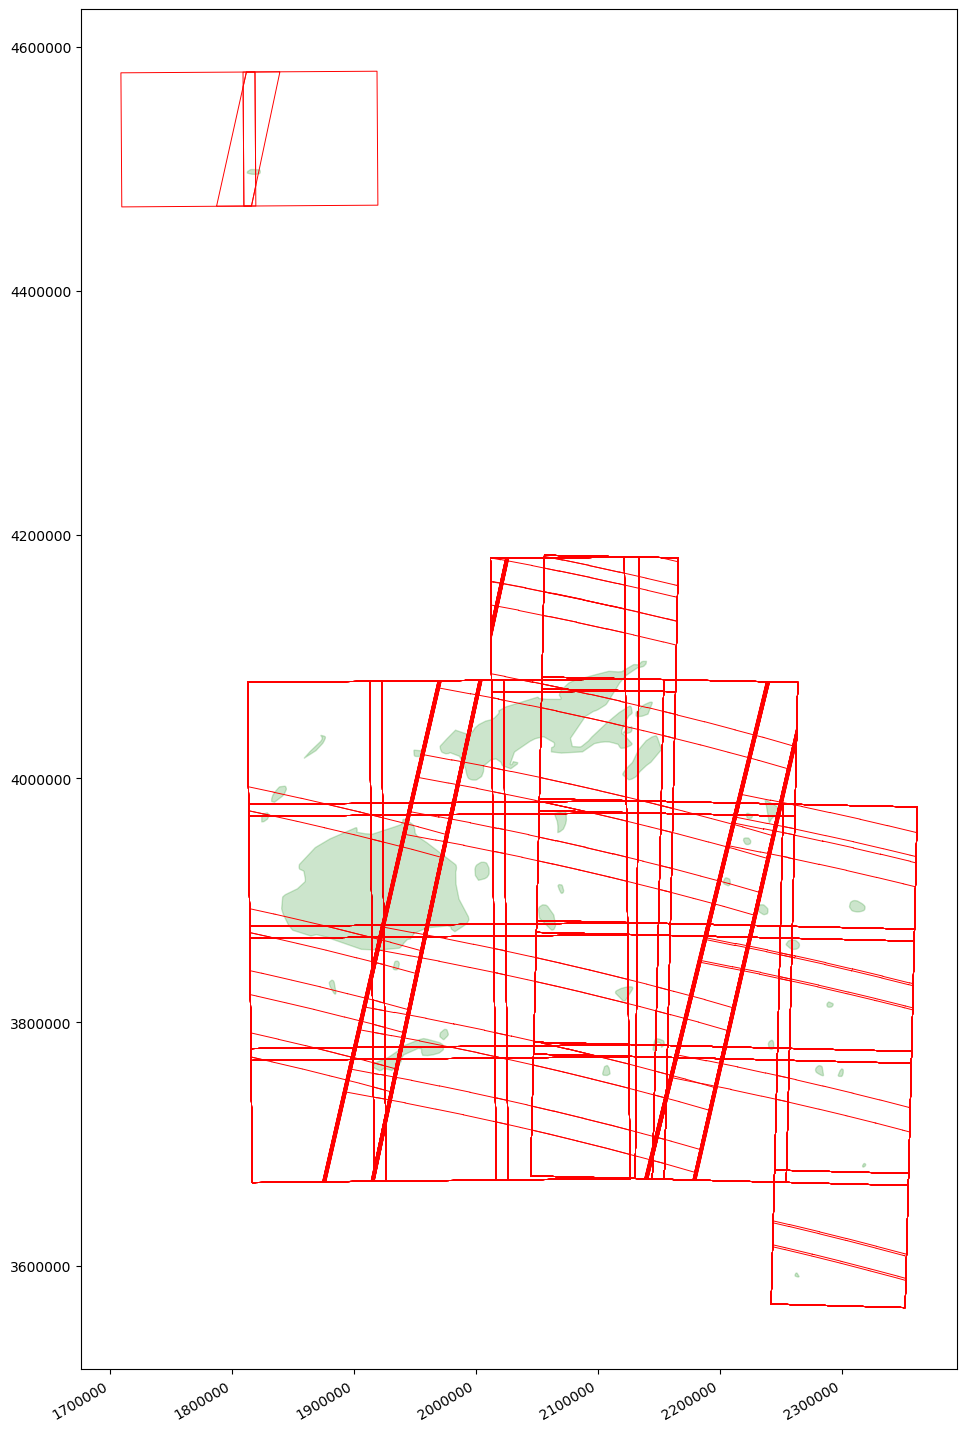

In [47]:
# Plot coverage
fig, ax = plt.subplots(figsize=(20,20),dpi=100)
fig.autofmt_xdate()
leg_patches=[]

x = country.to_crs({"init": "epsg:3460"}).plot(facecolor="g", edgecolor='g', ax=ax, alpha=0.2);
leg_patches.append(mpatches.Patch(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, label=country_name))

x = esa_l2a_precise.to_crs({"init": "epsg:3460"}).plot(facecolor="none", edgecolor='r', lw=0.7, ax=ax)
leg_patches.append(mpatches.Patch(facecolor="none", edgecolor='r', lw=0.7, label='Sentinel-2 Tiles'))
esa_l1c_precise.to_crs({"init": "epsg:3460"}).apply(lambda x: ax.annotate(s=x.Name, xy=x.geometry.centroid.coords[0], ha='center', fontsize=7.5),axis=1)




# x = country_s2_grans.to_crs({"init": "epsg:3460"}).plot(facecolor="none", edgecolor='r', lw=0.7, ax=ax)
# leg_patches.append(mpatches.Patch(facecolor="none", edgecolor='r', lw=0.7, label='Sentinel-2 Tiles'))
# country_s2_grans.to_crs({"init": "epsg:3460"}).apply(lambda x: ax.annotate(s=x.Name, xy=x.geometry.centroid.coords[0], ha='center', fontsize=7.5),axis=1)

# x = country_ls_grans.to_crs({"init": "epsg:3460"}).plot(facecolor="none", edgecolor='b', lw=0.7, ax=ax)
# leg_patches.append(mpatches.Patch(facecolor="none", edgecolor='b', lw=0.7, label='Landsat Tiles'))
# country_ls_grans.to_crs({"init": "epsg:3460"}).apply(lambda x: ax.annotate(s=x.PR, xy=x.geometry.centroid.coords[0], ha='center', fontsize=6),axis=1)

ax.set_title('asf')
ax.legend(handles=leg_patches, loc='upper center', shadow=True, ncol=5);
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);

# Consolidate dfs to **single processing campaign** list

In [64]:
s3_bucket = 'public-eo-data'
s3_dir = 'common_sensing/fiji/sentinel_2/'

s3_paths = s3_list_objects_paths(s3_bucket, s3_dir)
yamls = [i for i in s3_paths if i.split('/')[-1][-4:] == 'yaml']

In [69]:
s3_nms = [i.split('/')[3] for i in yamls]
esa_l2_nms = [i.replace('MSIL1C','MSIL2A') for i in esa_l2a_precise.scenename.values]
esa_l2a_precise['SAC_DONE'] = [ i in s3_nms for i in esa_l2_nms]

In [100]:
esa_l2a_precise['SAC_DONE'].value_counts()

True     2488
False    1319
Name: SAC_DONE, dtype: int64

In [101]:
to_do = []
for s, p in zip(esa_l2a_precise.title.values, esa_l2a_precise.SAC_DONE):
    if not p:
        to_do.append(s)
len(to_do),to_do[0]

(1319, 'S2A_MSIL2A_20200421T223011_N0214_R072_T60KWG_20200422T002013')

In [102]:
with open('../data/s2l2a_fiji_jobs.txt', 'a') as t:
    
    for v in to_do:

        t.write("rpush jobS2"+" '{"+'"in_scene": "'+ v +'", "s3_bucket": "public-eo-data", "s3_dir": "common_sensing/fiji/sentinel_2/"'+"}'" + '\n')

In [50]:
# DICTIONARY FOR CONSOLIDATED DF FIELDS
d = {
    'Scene_Name': [],
    'Acquisition_Date': [],
    'Granule_ID': [],
    'Geometry': [],
    'Prod_Size_MB': [],
    'ESA_Title': [],
    'ESA_UUID': [],
    'GCloud_Title': [],
    'GCloud_URL': [],
    'Prod_Access_Level': [],
    'S3_YN': [],
    'S3_Num': [],
    'S3_Size_MB': []
}

# References for new fields within existing dfs
refs = ['scenename','Acquisition Date', 'granules','geometry','size','title','uuid','PRODUCT_ID','BASE_URL','L1C','S3','S3','S3']

# Iterate ESA L1C products & populate fields
for index, row in esa_l1c_precise.iterrows():

    s3_res = s3_res_df.loc[s3_res_df.S3ScenName == row.scenename]
    l = 'L1C'
    
    for key, ref in zip(d.keys(), refs):
        try:
            if key == 'Prod_Access_Level':
                d[key].append(l)
                
            elif key == 'Prod_Size_MB':
                unit = row[ref][-2:]
                val = float(row[ref][:-3])
                if unit == 'MB':
                    d[key].append(val)
                elif unit == 'GB':
                    d[key].append(val/1000)
                    print('found a GB')
            
            elif key in ['GCloud_Title','GCloud_URL']:
                df = gc_l1c_match.loc[gc_l1c_match['scenename'] == row.scenename]
                if df.shape[0] == 1:
                    d[key].append(df[ref].values[0])
                else:
                    d[key].append('NaN')

            elif key == 'S3_YN':
                if s3_res.shape[0] == 0:
                    d[key].append('N')
                else:
                    d[key].append('Y')

            elif key == 'S3_Num':
                if s3_res.shape[0] == 0:
                    d[key].append('NaN')
                else:
                    d[key].append(s3_res.shape[0])
                    
            elif key == 'S3_Size_MB':
                if s3_res.shape[0] == 0:
                    d[key].append('NaN')
                else:
                    d[key].append(s3_res.Size.sum()/1000000)
                    
            else:
                d[key].append(row[ref])
                
        except:
            d[key].append('NaN')


# Iterate ESA L2A products & populate fields
for index, row in esa_l2a_precise.iterrows():

    s3_res = s3_res_df.loc[s3_res_df.S3ScenName == row.scenename]
    l = 'L2A'
    
    for key, ref in zip(d.keys(), refs):
        try:
            
            if key == 'Prod_Access_Level':
                d[key].append(l)
            
            elif key == 'Prod_Size_MB':
                unit = row[ref][-2:]
                val = float(row[ref][:-3])
                if unit == 'MB':
                    d[key].append(val)
                elif unit == 'GB':
                    d[key].append(val/1000)
                    print('found a GB')
            
            elif key in ['GCloud_Title','GCloud_URL']:
                df = gc_l2a_match.loc[gc_l2a_match['scenename'] == row.scenename]
                if df.shape[0] == 1:
                    d[key].append(df[ref].values[0])
                else:
                    d[key].append('NaN')

            elif key == 'S3_YN':
                if s3_res.shape[0] == 0:
                    d[key].append('N')
                else:
                    d[key].append('Y')

            elif key == 'S3_Num':
                if s3_res.shape[0] == 0:
                    d[key].append('NaN')
                else:
                    d[key].append(s3_res.shape[0])
                    
            elif key == 'S3_Size_MB':
                if s3_res.shape[0] == 0:
                    d[key].append('NaN')
                else:
                    d[key].append(s3_res.Size.sum()/1000000)
                    
            else:
                d[key].append(row[ref])
                
        except:
            d[key].append('NaN')


found a GB
found a GB
found a GB
found a GB


In [51]:
# Characteristics of consolidated df
df = pd.DataFrame(d)
print(df.shape)
df.head(2)

(9103, 13)


,Scene_Name,Acquisition_Date,Granule_ID,Geometry,Prod_Size_MB,ESA_Title,ESA_UUID,GCloud_Title,GCloud_URL,Prod_Access_Level,S3_YN,S3_Num,S3_Size_MB
0,S2A_MSIL1C_20190524T221941_T60KXD,2019-05-24 22:19:41.024000+00:00,60KXD,(POLYGON ((177.955833739406 -19.98223051191129...,697.32,S2A_MSIL1C_20190524T221941_N0207_R029_T60KXD_2...,00a983bc-5594-4134-aa39-07cc347c4d7e,S2A_MSIL1C_20190524T221941_N0207_R029_T60KXD_2...,gs://gcp-public-data-sentinel-2/tiles/60/K/XD/...,L1C,N,NaN,NaN
1,S2A_MSIL1C_20181212T220911_T01KBU,2018-12-12 22:09:11.024000+00:00,01KBU,"(POLYGON ((-179.86319 -19.77268241231112, -179...",648.55,S2A_MSIL1C_20181212T220911_N0207_R129_T01KBU_2...,3c2959ad-d299-46c8-939b-07123a6b718d,S2A_MSIL1C_20181212T220911_N0207_R129_T01KBU_2...,gs://gcp-public-data-sentinel-2/tiles/01/K/BU/...,L1C,N,NaN,NaN


# Estimate **Data Volumes** (MB etc.)
- **L1C**: Total no. prods, average product size, total size **from ESA**
- **L2A**: Total no. prods, average product size, total size **from ESA**
- L1C **Access vs ARD volume** ratio

### **L1C & L2A**: Total no. prods, average product size, total size **from ESA**

In [52]:
x = df[df.Prod_Access_Level == 'L1C']
print(f'L1C No.: {x.shape[0]} \nL1C Tot Access Size (TB): {round(x.Prod_Size_MB.sum()/1000000,2)} \nL1C Avg Access Size (MB): {round(x.Prod_Size_MB.mean(),2)}')
x = df[df.Prod_Access_Level == 'L2A']
print(f'L2A No.: {x.shape[0]} \nL2A Tot Access Size (TB): {round(x.Prod_Size_MB.sum()/1000000,2)} \nL2A Avg Access Size (MB): {round(x.Prod_Size_MB.mean(),2)}')
print('')
x = df
print(f'Combined No.: {x.shape[0]} \nCombined Tot Access Size (TB): {round(x.Prod_Size_MB.sum()/1000000,2)} \nCombined Avg Access Size (MB): {round(x.Prod_Size_MB.mean(),2)}')
print('')
x = df[df['S3_Size_MB']!='NaN']
print(f'Existing Matched No.: {x.shape[0]} \nExisting Matched Tot Size (TB): {round(x.S3_Size_MB.sum()/1000000,2)} \nExisting Matched Avg Size (MB): {round(x.S3_Size_MB.mean(),2)}')

# print(f'Current ARD No.: {x.shape[0]} \nCurrent ARD Tot Size (TB): {round(x.Size.sum()/1000000000000,2)} \nCurrent ARD Avg Size (MB): {round(x.Size.mean()/1000000,2)}')

L1C No.: 5296 
L1C Tot Access Size (TB): 2.54 
L1C Avg Access Size (MB): 480.46
L2A No.: 3807 
L2A Tot Access Size (TB): 2.44 
L2A Avg Access Size (MB): 642.08

Combined No.: 9103 
Combined Tot Access Size (TB): 4.99 
Combined Avg Access Size (MB): 548.05

Existing Matched No.: 0 
Existing Matched Tot Size (TB): 0.0 
Existing Matched Avg Size (MB): nan


In [275]:
x = df[df.Prod_Access_Level == 'L1C']
print(f'L1C No.: {x.shape[0]} \nL1C Tot Access Size (TB): {round(x.Prod_Size_MB.sum()/1000000,2)} \nL1C Avg Access Size (MB): {round(x.Prod_Size_MB.mean(),2)}')
x = df[df.Prod_Access_Level == 'L2A']
print(f'L2A No.: {x.shape[0]} \nL2A Tot Access Size (TB): {round(x.Prod_Size_MB.sum()/1000000,2)} \nL2A Avg Access Size (MB): {round(x.Prod_Size_MB.mean(),2)}')
print('')
x = df
print(f'Combined No.: {x.shape[0]} \nCombined Tot Access Size (TB): {round(x.Prod_Size_MB.sum()/1000000,2)} \nCombined Avg Access Size (MB): {round(x.Prod_Size_MB.mean(),2)}')
print('')
x = df[df['S3_Size_MB']!='NaN']
print(f'Existing Matched No.: {x.shape[0]} \nExisting Matched Tot Size (TB): {round(x.S3_Size_MB.sum()/1000000,2)} \nExisting Matched Avg Size (MB): {round(x.S3_Size_MB.mean(),2)}')

# print(f'Current ARD No.: {x.shape[0]} \nCurrent ARD Tot Size (TB): {round(x.Size.sum()/1000000000000,2)} \nCurrent ARD Avg Size (MB): {round(x.Size.mean()/1000000,2)}')

L1C No.: 5323 
L1C Tot Access Size (TB): 2.56 
L1C Avg Access Size (MB): 480.47
L2A No.: 2327 
L2A Tot Access Size (TB): 1.46 
L2A Avg Access Size (MB): 628.21

Combined No.: 7650 
Combined Tot Access Size (TB): 4.02 
Combined Avg Access Size (MB): 525.41

Existing Matched No.: 59 
Existing Matched Tot Size (TB): 0.04 
Existing Matched Avg Size (MB): 706.18


In [53]:
set(df.Prod_Access_Level.values)

{'L1C', 'L2A'}

In [54]:
print(df.shape)
df.columns




(9103, 13)


Index(['Scene_Name', 'Acquisition_Date', 'Granule_ID', 'Geometry',
       'Prod_Size_MB', 'ESA_Title', 'ESA_UUID', 'GCloud_Title', 'GCloud_URL',
       'Prod_Access_Level', 'S3_YN', 'S3_Num', 'S3_Size_MB'],
      dtype='object')

In [55]:
e = df[(df['GCloud_URL']!='NaN') & (df['Prod_Access_Level'] == 'L2A') & (df['Granule_ID'] == '60KYF')].sort_values(by='Acquisition_Date',ascending=True)
print(e.shape)
e.ESA_Title.values[0], e.GCloud_Title.values[0], e.Prod_Size_MB.values[0]

(96, 13)


('S2A_MSIL2A_20181215T221931_N0211_R029_T60KYF_20181215T234924',
 'S2A_MSIL2A_20181215T221931_N0211_R029_T60KYF_20181215T234924',
 870.09)

In [56]:
e = df[(df['GCloud_URL']=='NaN') & (df['Prod_Access_Level'] == 'L2A')].sort_values(by='Acquisition_Date',ascending=True)
print(e.shape)
n = 2
e.ESA_Title.values[n], e.GCloud_Title.values[n], e.Prod_Size_MB.values[n]

(144, 13)


('S2A_MSIL2A_20190124T221941_N0211_R029_T60KYF_20190124T234344', 'NaN', 933.72)

### L1C **Access vs ARD volume** ratio

In [57]:
# df = df.dropna(subset=['S3_Size_MB'])
df = df[df['S3_Size_MB']!='NaN']
df[["S3_Size_MB", "Prod_Size_MB"]] = df[["S3_Size_MB", "Prod_Size_MB"]].apply(pd.to_numeric)
print(df.shape)

(0, 13)


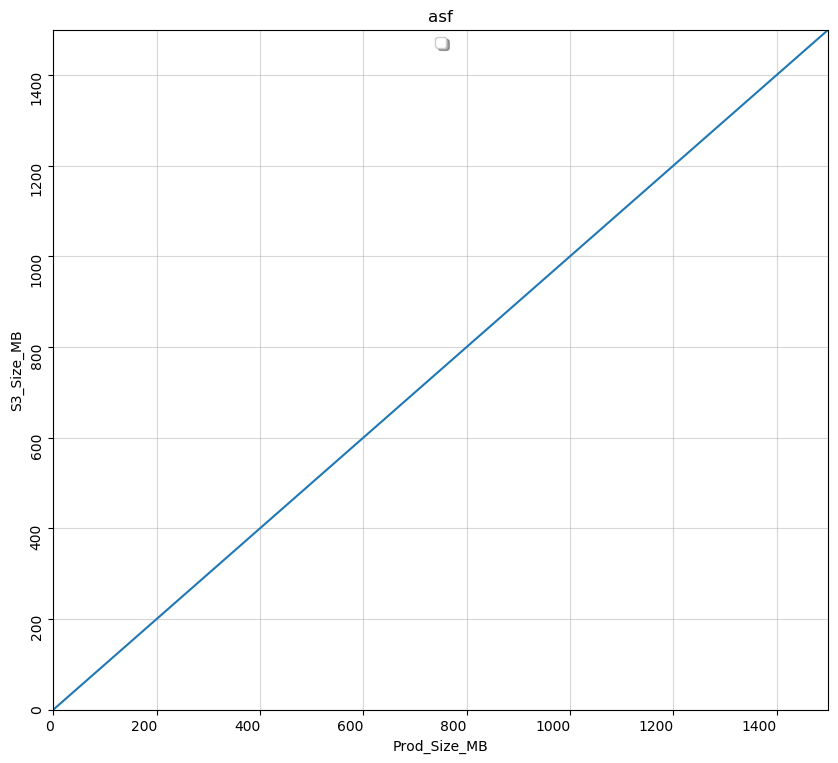

In [58]:
fig, ax = plt.subplots(figsize=(10,10),dpi=100)
fig.autofmt_xdate()
leg_patches=[]

df.plot.scatter(x='Prod_Size_MB',y='S3_Size_MB', ax=ax)
plt.plot((0,2000),(0,2000))
# plt.plot(np.unique(df.Prod_Size_MB.values), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

ax.set_title('asf')
ax.legend(handles=leg_patches, loc='upper center', shadow=True, ncol=5);
ax.grid(alpha=0.5);
ax.set_ylim(0,1500)
ax.set_xlim(0,1500)
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);

# **(2) Landsat**

In [39]:
pr = country_ls_grans
df = pd.read_csv('../Ancillary_Datasets/LANDSAT_8_C1.csv.gz') # latest csv can be found at - https://www.usgs.gov/land-resources/nli/landsat/bulk-metadata-service
df = df[df.row.isin(pr.ROW.values)&df.path.isin(pr.PATH.values)]
res3 = df
df = None

In [40]:
pr = country_ls_grans
df = pd.read_csv('../Ancillary_Datasets/LANDSAT_ETM_C1.csv.gz') # latest csv can be found at - https://www.usgs.gov/land-resources/nli/landsat/bulk-metadata-service
df = df[df.row.isin(pr.ROW.values)&df.path.isin(pr.PATH.values)]
res2 = df
df = None

In [41]:
pr = country_ls_grans
df = pd.read_csv('../Ancillary_Datasets/LANDSAT_TM_C1.csv.gz') # latest csv can be found at - https://www.usgs.gov/land-resources/nli/landsat/bulk-metadata-service
df = df[df.row.isin(pr.ROW.values)&df.path.isin(pr.PATH.values)]
res1 = df
df = None

In [332]:
res3.shape

(2545, 59)

In [333]:
res3.to_csv('./fiji_landsat8.csv')

In [300]:
l8_list = list(res3.LANDSAT_PRODUCT_ID.values)

In [413]:
# function for basic interaction with ESPA API - hacked together from their 'how to page'
def espa_api(endpoint, verb='get', body=None, uauth=None):
    """ Suggested simple way to interact with the ESPA JSON REST API """
    auth_tup = uauth if uauth else (username, password)
    response = getattr(requests, verb)(host + endpoint, auth=auth_tup, json=body)
    print('{} {}'.format(response.status_code, response.reason))
    data = response.json()
    if isinstance(data, dict):
        messages = data.pop("messages", None)  
        if messages:
            print(json.dumps(messages, indent=4))
    try:
        response.raise_for_status()
    except Exception as e:
        print(e)
        return None
    else:
        return data

In [416]:
# earth explorer credentials are required
host = 'https://espa.cr.usgs.gov/api/v1/'
#username = 'tom.jones'
#password = 'Welcome12'
username = 'sarah.cheesbrough'
password = 'SaCh_SatApps_USGS1'
# check login
print('GET /api/v1/user')
resp = espa_api('user')
print(json.dumps(resp, indent=4))

GET /api/v1/user
200 OK
{
    "email": "Sarah.Cheesbrough@sa.catapult.org.uk",
    "first_name": "Sarah",
    "last_name": "Cheesbrough",
    "roles": [
        "active"
    ],
    "username": "sarah.cheesbrough"
}


In [417]:
## CHECK CONFLICTING ORDERS ###

# check for any existing orders that may prevent imediate processing of a fresh requestttttt
print('GET /api/v1/list-orders')
filters = {"status": ["complete", "ordered"]}  # Here, we ignore any purged orders
resp = espa_api('list-orders', body=filters)
print(json.dumps(resp, indent=4))

GET /api/v1/list-orders
200 OK
[
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080031-821",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-061742-988",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-061537-204",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-061023-761",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-060110-664",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080959-437",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080506-662",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080423-123",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080244-635",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-053952-070"
]


In [331]:
### CHECK PRODUCT AVAILABILITY ###

# example of how to check available products for desired scenes
print('GET /api/v1/available-products')
avail_list = {'inputs': l8_list
             }
resp = espa_api('available-products', body=avail_list)
print(json.dumps(resp, indent=4))

GET /api/v1/available-products
200 OK
{
    "olitirs8_collection": {
        "inputs": [
            "LC08_L1GT_076069_20190924_20190925_01_RT",
            "LC08_L1GT_076071_20190924_20190925_01_RT",
            "LC08_L1GT_073069_20190919_20190920_01_RT",
            "LC08_L1TP_073071_20190919_20190920_01_RT",
            "LC08_L1TP_073072_20190919_20190920_01_RT",
            "LC08_L1TP_073073_20190919_20190920_01_RT",
            "LC08_L1GT_075069_20190917_20190918_01_RT",
            "LC08_L1GT_075071_20190917_20190918_01_RT",
            "LC08_L1TP_075072_20190917_20190918_01_RT",
            "LC08_L1TP_075073_20190917_20190918_01_RT",
            "LC08_L1GT_072069_20190912_20190917_01_T2",
            "LC08_L1GT_072071_20190912_20190917_01_T2",
            "LC08_L1TP_072072_20190912_20190917_01_T2",
            "LC08_L1TP_072073_20190912_20190917_01_T1",
            "LC08_L1GT_072074_20190912_20190917_01_T2",
            "LC08_L1GT_074069_20190910_20190917_01_T2",
            "LC

In [313]:
l8_list = list(res3.LANDSAT_PRODUCT_ID.values)
print(len(l8_list))
er = set(["LC08_L1GT_072069_20160224_20170329_01_T2",
            "LC08_L1GT_072071_20160224_20170329_01_T2",
            "LC08_L1GT_072072_20160224_20170329_01_T2",
            "LC08_L1TP_072073_20160224_20170329_01_T1",
            "LC08_L1GT_072074_20160224_20170329_01_T2",
            "LC08_L1GT_074069_20160222_20170329_01_T2",
            "LC08_L1GT_074071_20160222_20170329_01_T2",
            "LC08_L1TP_074072_20160222_20170329_01_T1",
            "LC08_L1TP_074073_20160222_20170329_01_T1",
            "LC08_L1TP_076069_20160220_20180202_01_T1"])
#er = ['LC08_L1TP_166051_20190814_20190814_01_RT', 'LC08_L1TP_166048_20190814_20190814_01_RT']
ls = l8_list
#ls = [x (if x is not in er) for x in l8_list]
for i in er: 
    print(i)
    ls.remove(er)
print(len(ls))

2545
LC08_L1TP_076069_20160220_20180202_01_T1


ValueError: list.remove(x): x not in list

In [324]:
### CREATE ORDER ###
# if any further subsetting is required. very recently acquired products are categorised as RT (as opposed to T1/T2). these are of insufficient certainty RE quality to be processed to ARD. this latency is unlikely to impact the non-NRT requirements of Common Sensing.
er = ['LC08_L1GT_072069_20160224_20170329_01_T2', 
      'LC08_L1GT_072071_20160224_20170329_01_T2', 
      'LC08_L1GT_072072_20160224_20170329_01_T2', 
      'LC08_L1TP_072073_20160224_20170329_01_T1', 
      'LC08_L1GT_072074_20160224_20170329_01_T2', 
      'LC08_L1GT_074069_20160222_20170329_01_T2', 
      'LC08_L1GT_074071_20160222_20170329_01_T2', 
      'LC08_L1TP_074072_20160222_20170329_01_T1', 
      'LC08_L1TP_074073_20160222_20170329_01_T1', 
      'LC08_L1TP_076069_20160220_20180202_01_T1'
     ]
#er = ['LC08_L1TP_166051_20190814_20190814_01_RT', 'LC08_L1TP_166048_20190814_20190814_01_RT']
l8_ls = [e for e in l8_list if e not in (er)]
l8_ls = [i for i in l8_list if 'RT' not in i]

# specifying differing products across the sensors
l8_prods = ["sr","bt","source_metadata","sr_ndvi","sr_evi","sr_savi","sr_msavi","sr_ndmi","sr_nbr","sr_nbr2","stats","pixel_qa"]
         
# determine available-products under their respective sensors
ls = l8_ls
print('GET /api/v1/available-products')
order = espa_api('available-products', body=dict(inputs=ls))
print(json.dumps(order, indent=4))

# replace available products with what we wish to process
for sensor in order.keys():
    if isinstance(order[sensor], dict) and order[sensor].get('inputs'):

        if set(l8_ls) & set(order[sensor]['inputs']):
            order[sensor]['products'] = l8_prods

# Add in the rest of the order information
#order['projection'] = projection
order['format'] = 'gtiff'
order['resampling_method'] = 'cc'
order['note'] = 'DY Veg'

# the order shoud now have changed from the original call available-products
print(json.dumps(order, indent=4))

GET /api/v1/available-products
200 OK
{
    "olitirs8_collection": {
        "inputs": [
            "LC08_L1GT_072069_20190912_20190917_01_T2",
            "LC08_L1GT_072071_20190912_20190917_01_T2",
            "LC08_L1TP_072072_20190912_20190917_01_T2",
            "LC08_L1TP_072073_20190912_20190917_01_T1",
            "LC08_L1GT_072074_20190912_20190917_01_T2",
            "LC08_L1GT_074069_20190910_20190917_01_T2",
            "LC08_L1TP_074071_20190910_20190917_01_T1",
            "LC08_L1TP_074072_20190910_20190917_01_T1",
            "LC08_L1TP_074073_20190910_20190917_01_T1",
            "LC08_L1GT_076069_20190908_20190917_01_T2",
            "LC08_L1GT_076071_20190908_20190917_01_T2",
            "LC08_L1GT_073069_20190903_20190917_01_T2",
            "LC08_L1GT_073071_20190903_20190917_01_T2",
            "LC08_L1GT_073072_20190903_20190917_01_T2",
            "LC08_L1GT_073073_20190903_20190917_01_T2",
            "LC08_L1GT_075069_20190901_20190916_01_T2",
            "LC

In [325]:
order['date_restricted']

{'sr_ndmi': ['LC08_L1GT_072069_20160224_20170329_01_T2',
  'LC08_L1GT_072071_20160224_20170329_01_T2',
  'LC08_L1GT_072072_20160224_20170329_01_T2',
  'LC08_L1TP_072073_20160224_20170329_01_T1',
  'LC08_L1GT_072074_20160224_20170329_01_T2',
  'LC08_L1GT_074069_20160222_20170329_01_T2',
  'LC08_L1GT_074071_20160222_20170329_01_T2',
  'LC08_L1TP_074072_20160222_20170329_01_T1',
  'LC08_L1TP_074073_20160222_20170329_01_T1',
  'LC08_L1TP_076069_20160220_20180202_01_T1'],
 'sr_savi': ['LC08_L1GT_072069_20160224_20170329_01_T2',
  'LC08_L1GT_072071_20160224_20170329_01_T2',
  'LC08_L1GT_072072_20160224_20170329_01_T2',
  'LC08_L1TP_072073_20160224_20170329_01_T1',
  'LC08_L1GT_072074_20160224_20170329_01_T2',
  'LC08_L1GT_074069_20160222_20170329_01_T2',
  'LC08_L1GT_074071_20160222_20170329_01_T2',
  'LC08_L1TP_074072_20160222_20170329_01_T1',
  'LC08_L1TP_074073_20160222_20170329_01_T1',
  'LC08_L1TP_076069_20160220_20180202_01_T1'],
 'sr': ['LC08_L1GT_072069_20160224_20170329_01_T2',
  'L

In [326]:
order.keys()
order.pop('date_restricted')
order.pop('oli8_collection')

{'inputs': ['LO08_L1GT_075069_20150210_20170413_01_T2',
  'LO08_L1GT_075071_20150210_20170413_01_T2',
  'LO08_L1TP_075072_20150210_20170413_01_T1',
  'LO08_L1TP_075073_20150210_20170413_01_T1'],
 'products': ['sr',
  'bt',
  'source_metadata',
  'sr_ndvi',
  'sr_evi',
  'sr_savi',
  'sr_msavi',
  'sr_ndmi',
  'sr_nbr',
  'sr_nbr2',
  'stats',
  'pixel_qa']}

In [327]:
### PLACE ORDER ###
print('POST /api/v1/order')
resp = espa_api('order', verb='post', body=order)
print(resp.keys)
print(json.dumps(resp, indent=4))

POST /api/v1/order
400 BAD REQUEST
{
    "errors": [
        {
            "8 validation errors": [
                "Requested sr_ndmi products are restricted by date. Remove olitirs8_collection scenes: [u'LC08_L1GT_072069_20160224_20170329_01_T2', u'LC08_L1GT_072071_20160224_20170329_01_T2', u'LC08_L1GT_072072_20160224_20170329_01_T2', u'LC08_L1TP_072073_20160224_20170329_01_T1', u'LC08_L1GT_072074_20160224_20170329_01_T2', u'LC08_L1GT_074069_20160222_20170329_01_T2', u'LC08_L1GT_074071_20160222_20170329_01_T2', u'LC08_L1TP_074072_20160222_20170329_01_T1', u'LC08_L1TP_074073_20160222_20170329_01_T1', u'LC08_L1TP_076069_20160220_20180202_01_T1']",
                "Requested sr_savi products are restricted by date. Remove olitirs8_collection scenes: [u'LC08_L1GT_072069_20160224_20170329_01_T2', u'LC08_L1GT_072071_20160224_20170329_01_T2', u'LC08_L1GT_072072_20160224_20170329_01_T2', u'LC08_L1TP_072073_20160224_20170329_01_T1', u'LC08_L1GT_072074_20160224_20170329_01_T2', u'LC08_L1GT_074

AttributeError: 'NoneType' object has no attribute 'keys'

In [299]:
res1

,THERMAL_LINES,sunAzimuth,REFLECTIVE_SAMPLES,upperRightCornerLatitude,cloudCover,MAP_PROJECTION_L1,cartURL,sunElevation,path,GROUND_CONTROL_POINTS_MODEL,...,GEOMETRIC_RMSE_MODEL_Y,sceneStopTime,upperLeftCornerLatitude,UTM_ZONE,DATE_L1_GENERATED,GRID_CELL_SIZE_THERMAL,DATUM,COLLECTION_NUMBER,sceneID,receivingStation
1991934,6941,69.371960,7751,-16.67039,74,UTM,https://earthexplorer.usgs.gov/download/extern...,43.805156,75,38,...,4.540,1993:084:21:26:55.7355600,-16.42119,60.0,2017/01/20,30,WGS84,1,LT40750721993084XXX02,XXX
1997875,6931,78.168028,7781,-16.66361,19,UTM,https://earthexplorer.usgs.gov/download/extern...,45.227916,75,52,...,5.157,1993:068:21:26:41.9641300,-16.41441,60.0,2017/01/19,30,WGS84,1,LT40750721993068XXX02,XXX
2016644,6941,104.797075,7811,-16.67021,24,UTM,https://earthexplorer.usgs.gov/download/extern...,49.645501,75,47,...,3.183,1993:004:21:25:31.1250600,-16.42101,60.0,2017/01/20,30,WGS84,1,LT40750721993004XXX02,XXX
2020871,6941,106.042960,7771,-16.67312,18,UTM,https://earthexplorer.usgs.gov/download/extern...,51.349212,75,85,...,3.846,1992:354:21:25:06.5463800,-16.42392,60.0,2017/01/21,30,WGS84,1,LT40750721992354AAA02,AAA
2080345,6861,47.753312,7761,-16.65889,17,UTM,https://earthexplorer.usgs.gov/download/extern...,31.214430,73,-1,...,NaN,1992:180:21:08:07.7508800,-16.40971,1.0,2017/01/22,30,WGS84,1,LT40730721992180XXX02,XXX
2080373,6871,48.265584,7761,-15.20513,10,UTM,https://earthexplorer.usgs.gov/download/extern...,32.349853,73,-1,...,NaN,1992:180:21:07:43.6369400,-14.95767,1.0,2017/01/23,30,WGS84,1,LT40730711992180XXX02,XXX
2086787,6871,47.800222,7781,-15.20766,13,UTM,https://earthexplorer.usgs.gov/download/extern...,32.877578,73,-1,...,NaN,1992:164:21:07:10.6311900,-14.96020,1.0,2017/01/22,30,WGS84,1,LT40730711992164XXX02,XXX
2086824,6861,47.284764,7771,-16.65199,6,UTM,https://earthexplorer.usgs.gov/download/extern...,31.742448,73,33,...,5.607,1992:164:21:07:34.6023800,-16.40281,1.0,2017/01/22,30,WGS84,1,LT40730721992164XXX02,XXX
2090151,6981,48.283327,7881,-15.20169,32,UTM,https://earthexplorer.usgs.gov/download/extern...,33.628362,74,42,...,5.709,1992:155:21:13:06.4352500,-14.95424,60.0,2017/01/22,30,WGS84,1,LT40740711992155XXX02,XXX
2090152,6981,47.741942,7891,-16.65477,24,UTM,https://earthexplorer.usgs.gov/download/extern...,32.493445,74,45,...,6.311,1992:155:21:13:30.5491900,-16.40559,60.0,2017/01/22,30,WGS84,1,LT40740721992155XXX02,XXX


# **(3) Sentinel-1**

In [103]:
# ESA Query
res = esa_api.query(aoi_wkt,platformname='Sentinel-1',producttype='GRD',sensoroperationalmode='IW')
esa_grd = esa_api.to_geodataframe(res)

Querying products: 100%|██████████| 821/821 [00:33<00:00, 24.60 products/s]


In [106]:
asf_grd_matches = get_s1_asf_urls(esa_grd.title.values)

In [107]:
asf_grd_matches.columns

Index(['Granule Name', 'Platform', 'Sensor', 'Beam Mode',
       'Beam Mode Description', 'Orbit', 'Path Number', 'Frame Number',
       'Acquisition Date', 'Processing Date', 'Processing Level', 'Start Time',
       'End Time', 'Center Lat', 'Center Lon', 'Near Start Lat',
       'Near Start Lon', 'Far Start Lat', 'Far Start Lon', 'Near End Lat',
       'Near End Lon', 'Far End Lat', 'Far End Lon', 'Faraday Rotation',
       'Ascending or Descending?', 'URL', 'Size (MB)', 'Off Nadir Angle',
       'Stack Size', 'Baseline Perp.', 'Doppler', 'GroupID'],
      dtype='object')

In [108]:
df = pd.merge(left=esa_grd, right=asf_grd_matches, how='left', left_on='title', right_on='Granule Name')

In [109]:
df[['Size (MB)']].mean()

Size (MB)    885.275732
dtype: float64

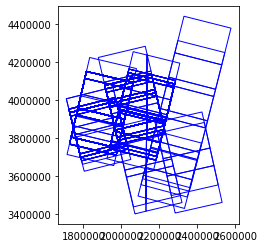

In [110]:
df.to_crs({"init": "epsg:3460"}).plot(facecolor='',edgecolor='b')

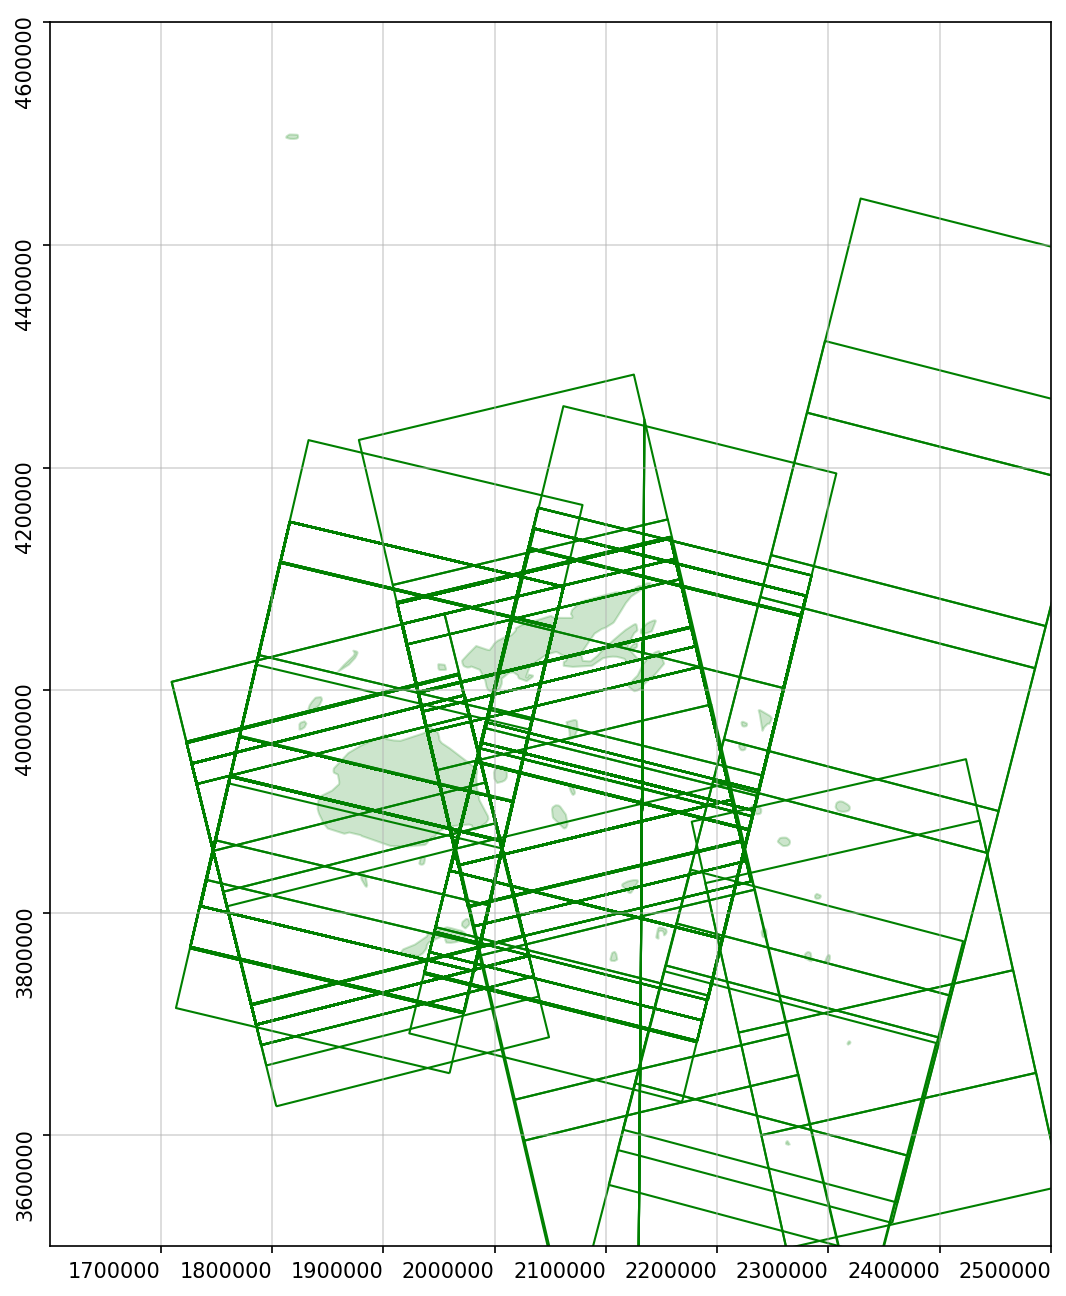

In [111]:
# Plot coverage
fig, ax = plt.subplots(figsize=(12,12),dpi=150)
fig.autofmt_xdate()
leg_patches=[]

# x = g.to_crs({"init": "epsg:3460"}).plot(edgecolor='black', ax=ax, alpha=0.1)
# leg_patches.append(mpatches.Patch(facecolor='none', edgecolor='black', lw=0.7, label='Anti-meridian'))

x = country.to_crs({"init": "epsg:3460"}).plot(facecolor="g", edgecolor='g', ax=ax, alpha=0.2);
leg_patches.append(mpatches.Patch(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, label=country_name))

df.to_crs({"init": "epsg:3460"}).plot(facecolor='',edgecolor='g',ax=ax)


# ax.set_title('asf')
# ax.legend(handles=leg_patches, loc='upper center', shadow=True, ncol=5);
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);
ax.set_xlim(1600001, 2500000);
ax.set_ylim(3500000, 4600000);

In [112]:
# Create bool for intersection between any tiles 
for n, g in zip(country.NAME, country.geometry):
    esa_grd[n] = esa_grd.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(g))
# Filter based on any True intersections
esa_grd[country_name] = esa_grd[esa_grd[country.NAME.values]].any(1)
esa_grd_c = esa_grd[esa_grd[country_name]==True]

In [124]:
# Create bool for intersection between any tiles 
for n, g in zip(country.NAME, country.geometry):
    df[n] = df.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(g))
# Filter based on any True intersections
df[country_name] = df[df[country.NAME.values]].any(1)
df_c = df[df[country_name]==True]

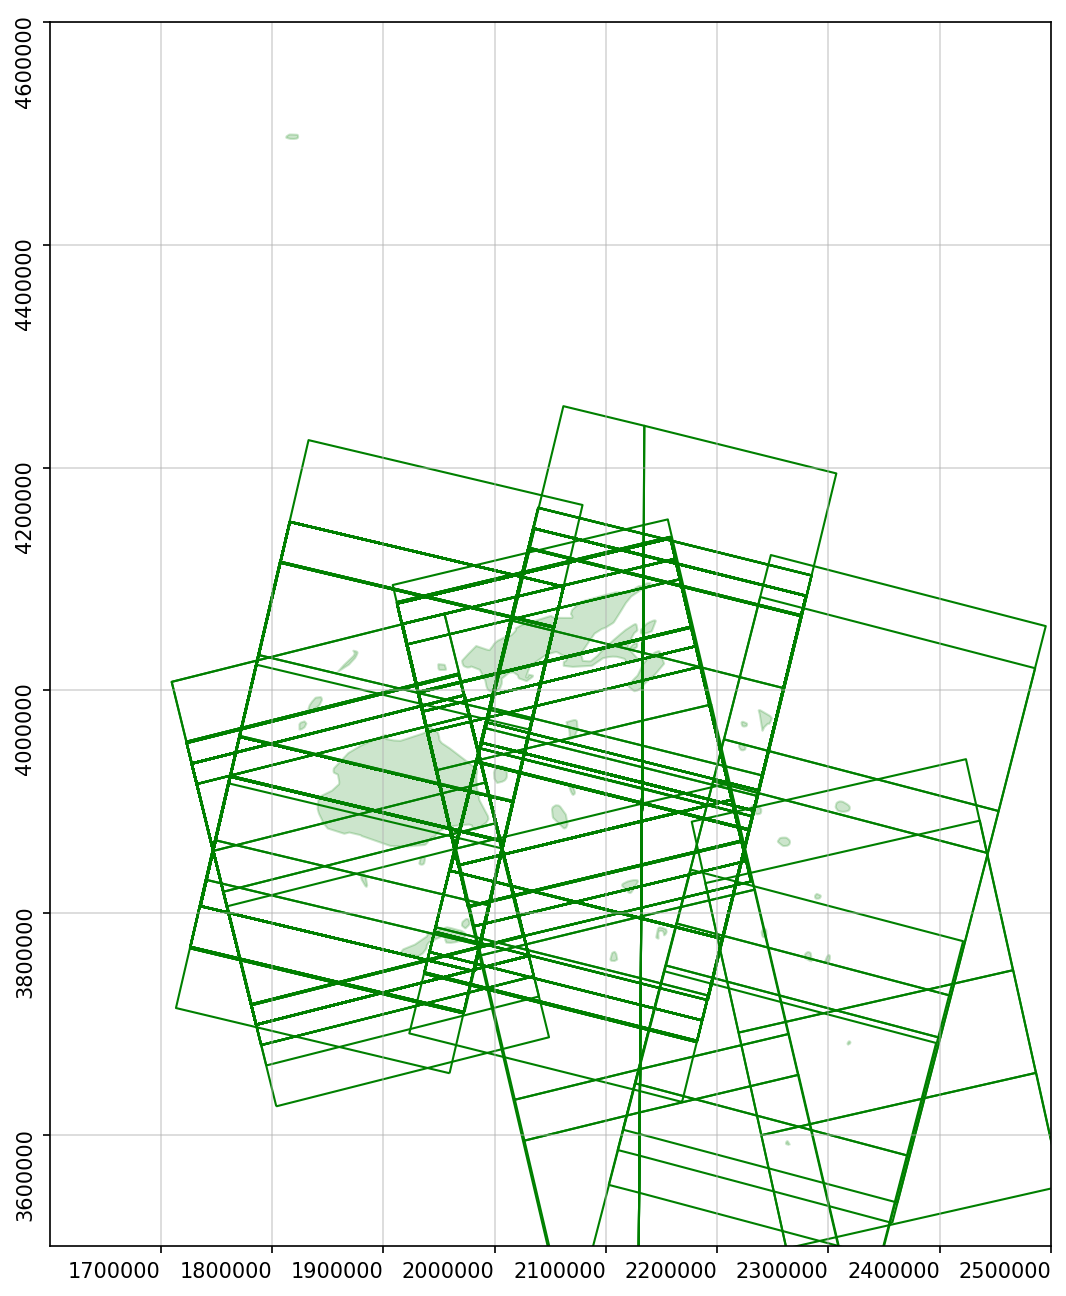

In [125]:
# Plot coverage
fig, ax = plt.subplots(figsize=(12,12),dpi=150)
fig.autofmt_xdate()
leg_patches=[]

# x = g.to_crs({"init": "epsg:3460"}).plot(edgecolor='black', ax=ax, alpha=0.1)
# leg_patches.append(mpatches.Patch(facecolor='none', edgecolor='black', lw=0.7, label='Anti-meridian'))

x = country.to_crs({"init": "epsg:3460"}).plot(facecolor="g", edgecolor='g', ax=ax, alpha=0.2);
leg_patches.append(mpatches.Patch(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, label=country_name))

df_c.to_crs({"init": "epsg:3460"}).plot(facecolor='',edgecolor='g',ax=ax)

# ax.set_title('asf')
# ax.legend(handles=leg_patches, loc='upper center', shadow=True, ncol=5);
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);
ax.set_xlim(1600001, 2500000);
ax.set_ylim(3500000, 4600000);

select scenes over mainisland for product development

In [126]:
non_am = "POLYGON((177.07301550947307 -17.17940113068343,177.72120886884807 -17.17940113068343,177.72120886884807 -18.689732935559707,177.07301550947307 -18.689732935559707,177.07301550947307 -17.17940113068343))"
non_am = pd.DataFrame(data={'geometry': [non_am]})
non_am['geometry'] = non_am['geometry'].apply(wkt.loads)
non_am['NAME'] = 'SUB'
non_am = gpd.GeoDataFrame(non_am, geometry='geometry', crs=('epsg:4326'))
non_am.crs = from_epsg(4326)

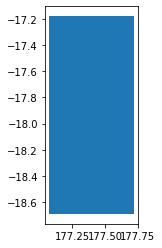

In [127]:
non_am.plot()

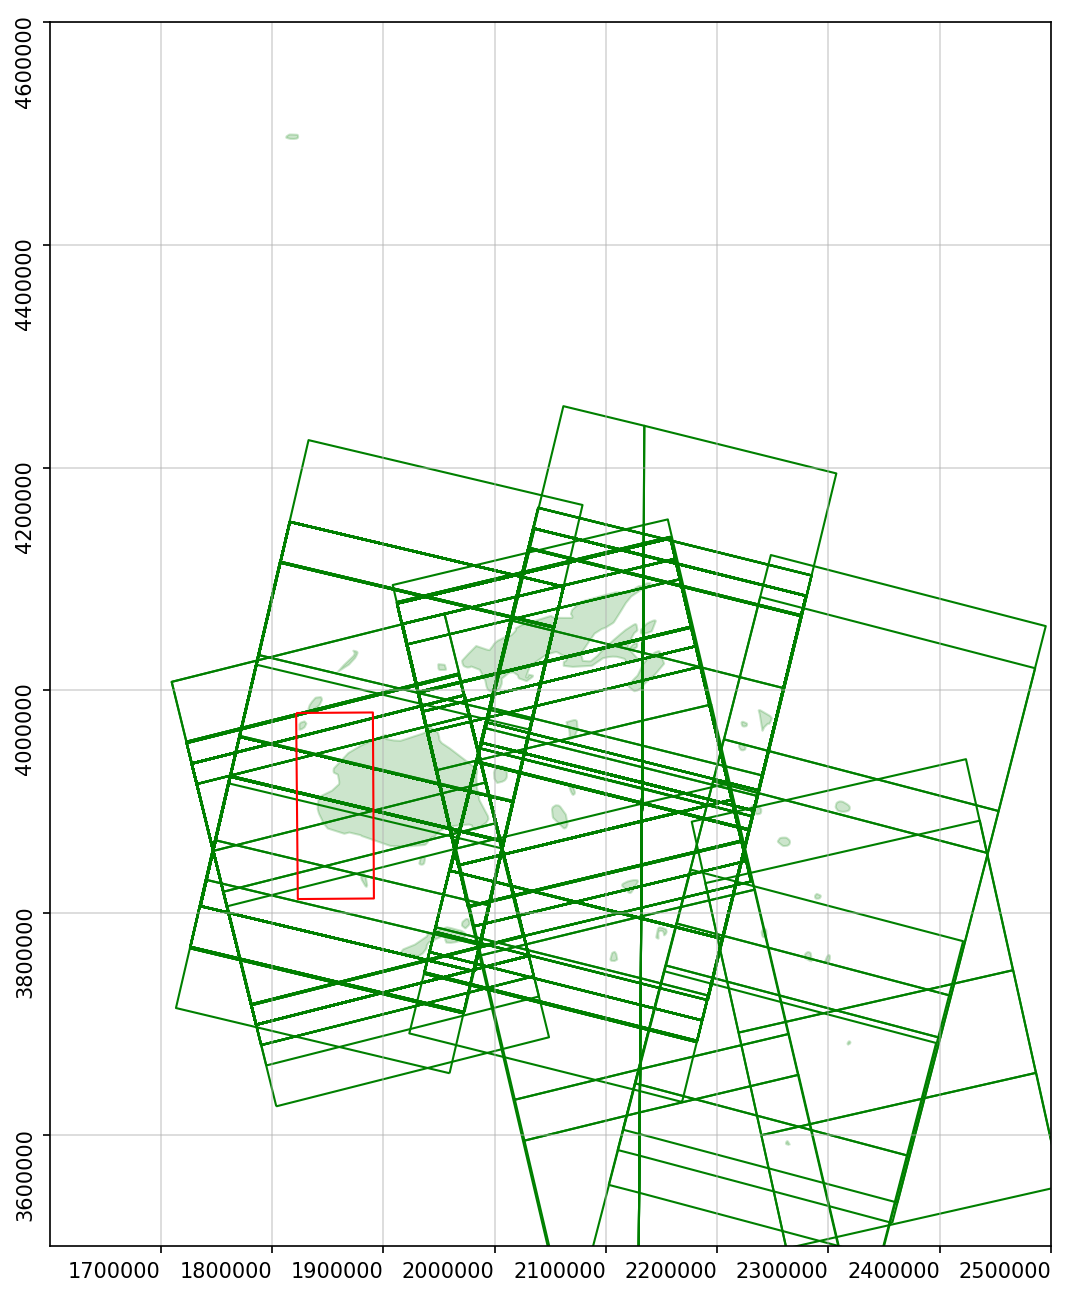

In [128]:
# Plot coverage
fig, ax = plt.subplots(figsize=(12,12),dpi=150)
fig.autofmt_xdate()
leg_patches=[]

# x = g.to_crs({"init": "epsg:3460"}).plot(edgecolor='black', ax=ax, alpha=0.1)
# leg_patches.append(mpatches.Patch(facecolor='none', edgecolor='black', lw=0.7, label='Anti-meridian'))

x = country.to_crs({"init": "epsg:3460"}).plot(facecolor="g", edgecolor='g', ax=ax, alpha=0.2);
leg_patches.append(mpatches.Patch(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, label=country_name))

df_c.to_crs({"init": "epsg:3460"}).plot(facecolor='',edgecolor='g',ax=ax)

non_am.to_crs({"init": "epsg:3460"}).plot(facecolor='',edgecolor='r',ax=ax)

# ax.set_title('asf')
# ax.legend(handles=leg_patches, loc='upper center', shadow=True, ncol=5);
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);
ax.set_xlim(1600001, 2500000);
ax.set_ylim(3500000, 4600000);

In [129]:
# # Create bool for intersection between any tiles 
# for n, g in zip(non_am.NAME, non_am.geometry):
#     df_c[n] = df_c.geometry.apply(lambda x: gpd.GeoSeries(x, crs={"init": "epsg:4326"}).to_crs({"init": "epsg:3460"})).intersects(g.to_crs('epsg:3460')))

# a = overall_aoi_gdf.to_crs({"init": "epsg:3460"}) # speed intersect up by repro-ing aoi first

non_am_fij = non_am.to_crs({"init": "epsg:3460"})
df_c['des'] = df_c.to_crs({"init": "epsg:3460"}).geometry.map(lambda x: x.intersects(non_am_fij.geometry.any())) # repro and test intersect
df_c_nonam = df_c[df_c['des']==True] # subset
    
    

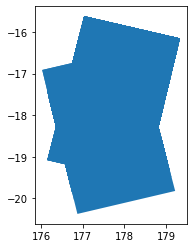

In [130]:
df_c_nonam.plot()

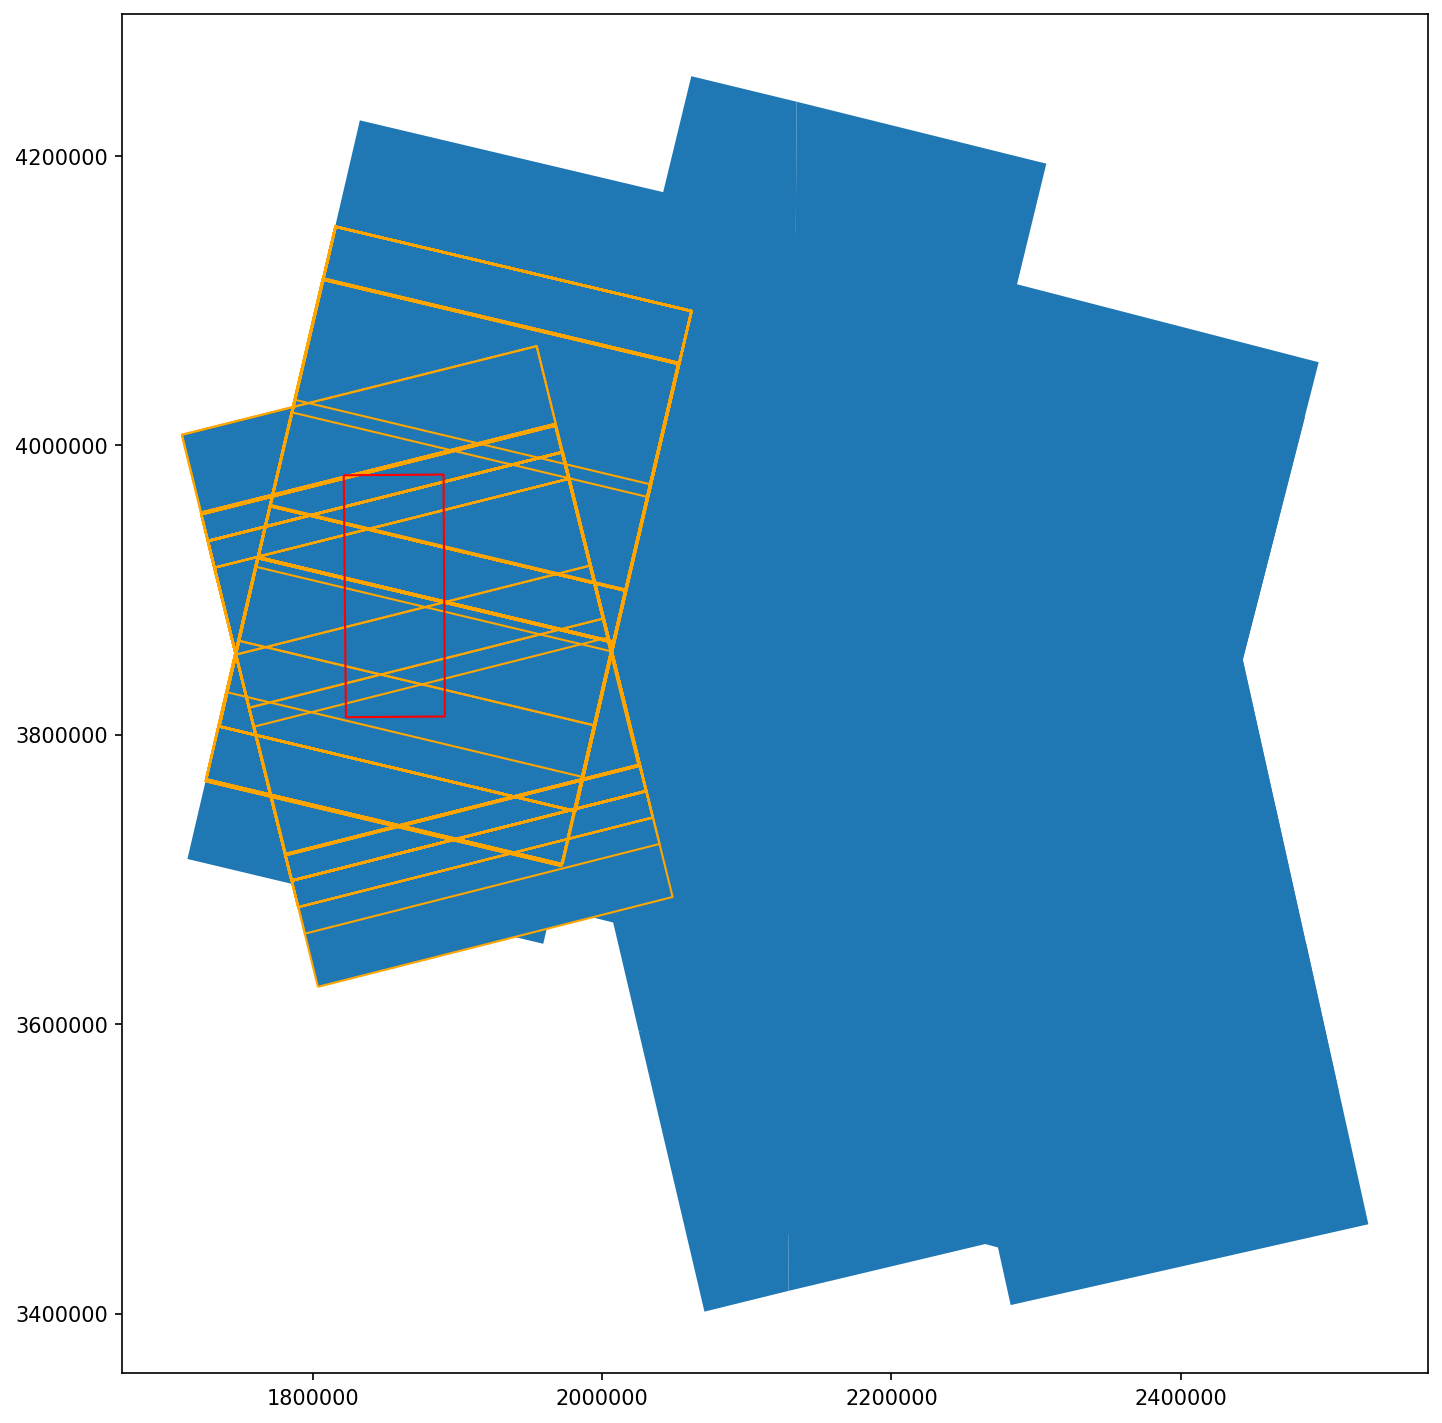

In [131]:
fig, ax = plt.subplots(figsize=(12,12),dpi=150)
df_c.to_crs("epsg:3460").plot(ax=ax)
df_c_nonam.to_crs("epsg:3460").plot(ax=ax, facecolor='', edgecolor='orange')
non_am.to_crs("epsg:3460").plot(ax=ax, facecolor='', edgecolor='red')

In [132]:
s3_bucket = 'public-eo-data'
s3_dir = 'common_sensing/fiji/sentinel_1/'

s3_paths = s3_list_objects_paths(s3_bucket, s3_dir)
yamls = [i for i in s3_paths if i.split('/')[-1][-4:] == 'yaml']

In [136]:
yamls[0].split('/')[-2]

'S1A_IW_GRDH_1SDV_20170213T063946'

In [156]:
df_c_nonam['SAC_DONE'] = [ i[:32] in [j.split('/')[-2] for j in yamls] for i in df_c_nonam.title.values ]

In [158]:
df_c_nonam['SAC_DONE'].value_counts()

True     253
False    127
Name: SAC_DONE, dtype: int64

In [159]:
to_do = []
for s, p in zip(df_c_nonam.title.values, df_c_nonam.SAC_DONE):
    if not p:
        to_do.append(s)
len(to_do),to_do[0]

(127, 'S1A_IW_GRDH_1SDV_20200422T064006_20200422T064041_032236_03BA9B_BCA2')

In [160]:
with open('../data/s1_fijinonam_jobs.txt', 'a') as t:
    
    for v in to_do:

        t.write("rpush jobS1"+" '{"+'"in_scene": "'+ v +'", "s3_bucket": "public-eo-data", "s3_dir": "common_sensing/fiji/sentinel_1/", "ext_dem": "common_sensing/ancillary_products/SRTM1Sec/SRTM30_Fiji_E.tif"'+"}'" + '\n')

In [69]:
with open('s1vitilevu_jobs_all.txt', 'a') as t:
    
    for v in df_c_nonam.title.values[:]:
#         print(v)

#         if (int(v.split('_')[4][:8]) <= 20190328):
#             print(v.split('_')[4][:8])
        t.write("rpush jobS1"+" '{"+'"in_scene": "'+ v +'", "s3_bucket": "public-eo-data", "s3_dir": "common_sensing/fiji/sentinel_1/", "ext_dem": "common_sensing/ancillary_products/SRTM1Sec/SRTM30_Fiji_E.tif"'+"}'" + '\n')

In [117]:
non_am

,geometry,NAME
0,"POLYGON ((177.07302 -17.17940, 177.72121 -17.1...",SUB


In [118]:
# Create bool for intersection between any tiles 
for n, g in zip(non_am.NAME, non_am.geometry):
    esa_grd_c[n] = esa_grd_c.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(g))


In [119]:
# Filter based on any True intersections
esa_grd_c['SUB'] = esa_grd_c[esa_grd_c['SUB']].any(1)
sub_esa_grd_c = esa_grd_c[esa_grd_c['SUB']==True]


In [120]:
sub_esa_grd_c.shape

(658, 36)

In [121]:
esa_grd_c.shape

(817, 36)

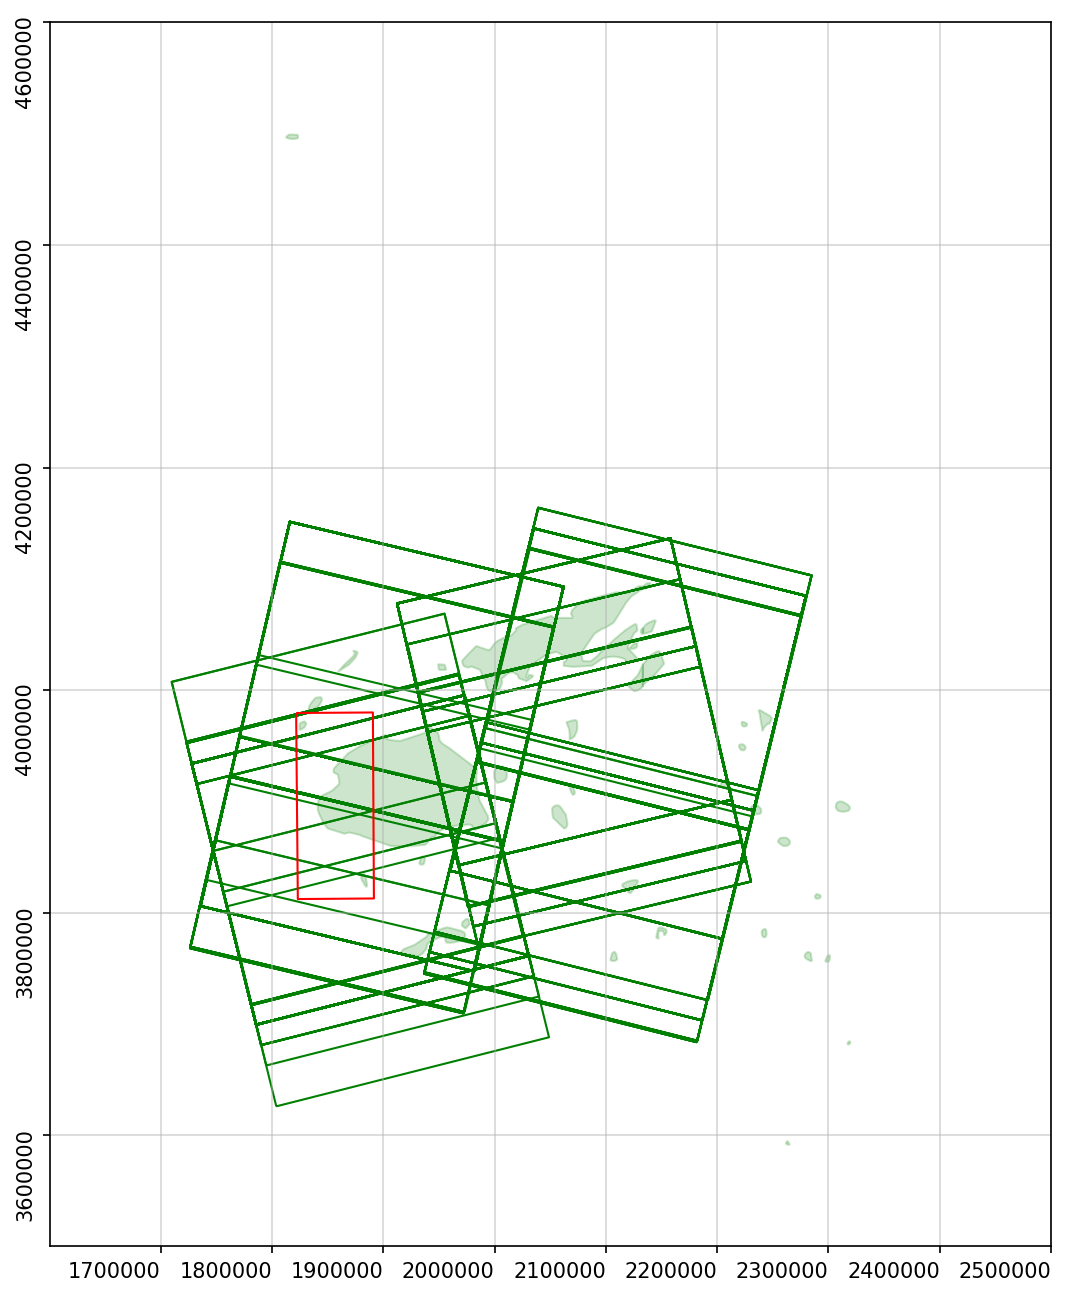

In [122]:
# Plot coverage
fig, ax = plt.subplots(figsize=(12,12),dpi=150)
fig.autofmt_xdate()
leg_patches=[]

# x = g.to_crs({"init": "epsg:3460"}).plot(edgecolor='black', ax=ax, alpha=0.1)
# leg_patches.append(mpatches.Patch(facecolor='none', edgecolor='black', lw=0.7, label='Anti-meridian'))

x = country.to_crs({"init": "epsg:3460"}).plot(facecolor="g", edgecolor='g', ax=ax, alpha=0.2);
leg_patches.append(mpatches.Patch(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, label=country_name))

sub_esa_grd_c.to_crs({"init": "epsg:3460"}).plot(facecolor='',edgecolor='g',ax=ax)

non_am.to_crs({"init": "epsg:3460"}).plot(facecolor='',edgecolor='r',ax=ax)

# ax.set_title('asf')
# ax.legend(handles=leg_patches, loc='upper center', shadow=True, ncol=5);
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);
ax.set_xlim(1600001, 2500000);
ax.set_ylim(3500000, 4600000);